<a href="https://colab.research.google.com/github/sravanisasu/10k-sample/blob/main/CNN_10kreports.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/sravanisasu/10k-sample

Cloning into '10k-sample'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 9554 (delta 0), reused 1 (delta 0), pack-reused 9548
Receiving objects: 100% (9554/9554), 158.13 MiB | 19.51 MiB/s, done.
Resolving deltas: 100% (335/335), done.
Checking out files: 100% (10019/10019), done.


In [2]:
# Importing the required packages

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import numpy as np
from numpy import random
from pickle import load
from numpy import array
import os
import re
from keras.utils.vis_utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Embedding
from keras import optimizers
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.merge import concatenate
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.metrics import RootMeanSquaredError
import matplotlib.pyplot as plt
from keras.layers.advanced_activations import LeakyReLU
import tensorflow as tf

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
#Define file paths required for the model

# embedding bin file
embed_file = "/content/sim.expand.200d.vec"

#Define Hyper parameters
max_inp_len = 20000
# the dimension of vectors to be used
embed_dim = 200
rounding = 6
# filter sizes of the different conv layers 
filter_sizes = [3,4,5]
num_filters = 1
pool_size = 32
# dropout probability
drop = 0.5
batch_size = 50
learning_rate = 0.001
epochs = 30

In [4]:
#define embedding dictionary and embed matrix for the vocabulary
embeddings_dic = dict()
f = open(embed_file,encoding='utf8')
with open(embed_file, 'r', encoding='utf-8') as e_file:
  for line in e_file:
    splitlines = line.split()
    word = splitlines[0].strip()
    coefs = np.asarray(splitlines[1:], dtype='float32')
    embeddings_dic[word] = coefs

print("length of embedding dictionary",len(embeddings_dic))



length of embedding dictionary 70428


In [5]:
vocabulary_size = len(embeddings_dic.keys())
embed_token = Tokenizer()
embed_token.fit_on_texts(embeddings_dic.keys())
embedding_matrix = np.zeros((vocabulary_size, embed_dim))
for word, index in embed_token.word_index.items():
  embedding_matrix[index] = embeddings_dic.get(word)
print("embedding_matrix dimension",len(embedding_matrix),len(embedding_matrix[0]))
print("no of token in the tokenizer",len(embed_token.word_index) + 1)

embedding_matrix dimension 70428 200
no of token in the tokenizer 70428


In [6]:
#function to pre process the document
def process_doc(path_file,embed_token) :

  #tokenizing the words 
  with open(path_file,'r', encoding='utf-8') as tok_file :
    file_words = list(tok_file)[0].split()
    
  #removing the stop words
  stop_words = set(stopwords.words('english'))
  filtered_words = []  
  for word in file_words: 
      if word not in stop_words and word.isalpha(): 
          filtered_words.append(word)

  # applying stemming using PorterStemmer

  p_stemmer = PorterStemmer()
  stem_words=[]
  for word in filtered_words:
    stem_words.append(p_stemmer.stem(word))
    
  #tokenizing the words using the embed token
  tokens=[]
  for word in stem_words:
    try:
      tokens.append(embed_token.word_index[word])
    except:
      tokens.append(1)

  tokens.extend([0]*(max_inp_len-len(tokens)))

  return tokens[:20000]

In [7]:
#input dataset
def input_data(meta_file):
  documents = list()
  with open(meta_file,'r', encoding='utf-8') as m_file :
    year = meta_file.split('/')[3].split('.')[0]
    dir_path = os.path.dirname(meta_file) + '/' +year+'.tok'
    for line in m_file.readlines():
      inp_path_file = dir_path +'/'+ line.split()[0] + '.mda'
      # get tokens for the doc
      tokens = process_doc(inp_path_file,embed_token)
      documents.append(tokens)
  return documents

In [8]:
input_X = input_data('/content/10k-sample/2007.meta.txt')
print(len(input_X))
input_X.extend(input_data('/content/10k-sample/2008.meta.txt'))
print(len(input_X))
input_X.extend(input_data('/content/10k-sample/2009.meta.txt'))
print(len(input_X))

2495
5004
7571


In [9]:
#output dataset
def output_data(out_path_file):
  output=[]
  with open(out_path_file,'r', encoding='utf-8') as out_file :
    for line in out_file.readlines():
      output.append(float(line.split()[0]))
  return output

In [10]:
output_Y = output_data('/content/10k-sample/2007.logvol.+12.txt')
print(len(output_Y))
output_Y.extend(output_data('/content/10k-sample/2008.logvol.+12.txt'))
print(len(output_Y))
output_Y.extend(output_data('/content/10k-sample/2009.logvol.+12.txt'))
print(len(output_Y))

2495
5004
7571


In [11]:
print(np.array(input_X).shape)
#np.array(output_Y).shape

(7571, 20000)


In [12]:
def define_model(max_inp_len,vocabulary_size,embed_dim,filter_sizes,num_filters,pool_size,drop,learning_rate):
  
  # input and embedding matrix
  inputs = Input(shape=(max_inp_len,))
  embedding = Embedding(vocabulary_size, embed_dim, weights=[embedding_matrix],trainable = False)(inputs)

  custom_objects={'leaky_relu': tf.nn.leaky_relu}

  # channel 1 convolution and local max-pooling
  convolution_1 = Conv1D(filters=num_filters, kernel_size=filter_sizes[0], activation=custom_objects['leaky_relu'])(embedding)
  pool_1 = MaxPooling1D(pool_size=pool_size)(convolution_1)
  
	# channel 2 convolution and local max-pooling
  convolution_4 = Conv1D(filters=num_filters, kernel_size=filter_sizes[1], activation=custom_objects['leaky_relu'])(embedding)
  pool_2 = MaxPooling1D(pool_size=pool_size)(convolution_4)
  
  # channel 3 convolution and local max-pooling
  convolution_5 = Conv1D(filters=num_filters, kernel_size=filter_sizes[2], activation=custom_objects['leaky_relu'])(embedding)
  pool_3 = MaxPooling1D(pool_size=pool_size)(convolution_5)
  
  # merge and dropout
  merged = concatenate([pool_1,pool_2,pool_3],axis=1)
  drop_out = Dropout(drop)(merged)
  flat = Flatten()(drop_out)

  # 2 fully connected layers
  dense1 = Dense(200, activation=custom_objects['leaky_relu'])(flat)
  outputs = Dense(1, activation=custom_objects['leaky_relu'])(dense1)
  model = Model(inputs=[inputs], outputs=outputs)
    
  opt = optimizers.SGD(learning_rate=learning_rate)
  model.compile(loss='mse', optimizer=opt, metrics=[RootMeanSquaredError()])

	# summarize
  print(model.summary())
  return model

In [13]:
input_X = np.array(input_X)
output_Y = np.array(output_Y)
#output_Y = tf.keras.utils.normalize(output_Y)
print(input_X.shape)
print(output_Y.shape)
from sklearn import model_selection as ms

x_train, x_test, y_train, y_test = ms.train_test_split(input_X, output_Y, random_state = 1 ,test_size=0.33)

print("total input shape",input_X.shape)
print("total output shape",output_Y.shape)
print("training input shape",x_train.shape)
print("training output shape",y_train.shape)
print("testing input shape",x_test.shape)
print("testing output shape",y_test.shape)

# define model
model = define_model(max_inp_len,vocabulary_size,embed_dim,filter_sizes,num_filters,64,drop,learning_rate)
# fit mode
history = model.fit(x_train, y_train,batch_size=batch_size,epochs=epochs)
model.save('model.h5')



(7571, 20000)
(7571,)
total input shape (7571, 20000)
total output shape (7571,)
training input shape (5072, 20000)
training output shape (5072,)
testing input shape (2499, 20000)
testing output shape (2499,)
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 20000)]      0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 20000, 200)   14085600    input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 19998, 1)     601         embedding[0][0]                  
____________________________________________________________________________

In [14]:
loss_T, RMSE_T = model.evaluate(x_train, y_train, verbose=0)
print('Train Error: %f' % (RMSE_T))
 
# evaluate model on test dataset dataset
loss_V, RMSE_V = model.evaluate(x_test,y_test, verbose=0)
print('Test Error: %f' % (RMSE_V))

Train Error: 0.510544
Test Error: 0.510756


dict_keys(['loss', 'root_mean_squared_error'])


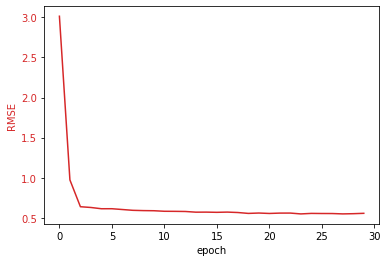

In [15]:
print(history.history.keys())
fig, ax1 = plt.subplots()
epochs_arr =[i for i in range(0,epochs)]
color = 'tab:red'
ax1.set_xlabel('epoch')
ax1.set_ylabel('RMSE', color=color)
ax1.plot(epochs_arr, history.history['root_mean_squared_error'], color=color)
ax1.tick_params(axis='y', labelcolor=color)
plt.show()
